# Load Library & Preprocess Data 

In [1]:
import os
GPU = f'0'
os.environ['CUDA_VISIBLE_DEVICES']=GPU
import random
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
from sklearn.model_selection import train_test_split

from config import *
from Models.models import yoloV3, yoloLoss

### Set Seed

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

### Load Data 

In [3]:
df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [4]:
df.head()

,image_path,x_rankle,y_rankle,x_rknee,y_rknee,x_rhip,y_rhip,x_lhip,y_lhip,x_lknee,...,x_lshoulder,y_lshoulder,x_lelbow,y_lelbow,x_lwrist,y_lwrist,x_human,y_human,w_human,h_human
0,015601864.jpg,394,620,269,616,185,573,188,647,221,...,185,692,240,693,313,688,257,594,286,205
1,015601864.jpg,293,895,279,910,223,945,218,1012,315,...,206,924,203,1013,263,955,222,952,229,229
2,015599452.jpg,0,0,0,0,543,806,593,720,0,...,299,719,516,711,466,545,329,619,525,525
3,015599452.jpg,0,0,0,0,607,987,571,1194,0,...,269,1145,475,1226,433,1096,412,1010,533,533
4,015599452.jpg,0,0,0,0,537,228,536,74,0,...,251,26,423,26,0,0,315,133,506,506


### Split train & validation Data 

In [5]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=SEED)

In [6]:
train_df.shape, val_df.shape

((25994, 37), (2889, 37))

# Datagenerator

In [ ]:
class Datagenerator(tf.keras.utils.Sequence):
    def __init__(self, df, list_IDs, batch_size, image_paths=None, size=416, shuffle=True, random_state=42, mode='fit'):
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.image_paths = image_paths
        self.size = size
        self.shuffle = shuffle
        self.random_state = random_state
        self.mode = mode
        self.df = df
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_IDs_batch = [self.list_IDs[i] for i in indexes]
        
        X, img_hs, img_ws = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, img_hs, img_ws)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict"')
        
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X, img_hs, img_ws = [], [], []
        for i, ID in enumerate(list_IDs_batch):
            img_path = self.image_paths[ID]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.
            img_hs.append(img.shape[0])
            img_ws.append(img.shape[1])
            img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_AREA)
            X.append(img)
        X = np.array(X)
        return X, img_hs, img_ws
    
    def __generate_Y(self, list_IDs_batch, img_hs, img_ws):
        labels = []
        for i, ID in enumerate(list_IDs_batch):
            keypoints = self.df[self.df.index == ID].iloc[:,1:].to_numpy()[0]
            

[334.0, 952.0, 346.0, 964.0]
[275.0, 941.0, 287.0, 953.0]
[209.0, 929.0, 221.0, 941.0]
[213.0, 898.0, 225.0, 910.0]
[283.0, 904.0, 295.0, 916.0]
[348.0, 887.0, 360.0, 899.0]
[211.0, 914.0, 223.0, 926.0]
[136.0, 930.0, 148.0, 942.0]
[117.0, 929.0, 129.0, 941.0]
[78.0, 928.0, 90.0, 940.0]
[168.0, 965.0, 180.0, 977.0]
[180.0, 975.0, 192.0, 987.0]
[138.0, 956.0, 150.0, 968.0]
[133.0, 903.0, 145.0, 915.0]
[157.0, 861.0, 169.0, 873.0]
[141.0, 828.0, 153.0, 840.0]
[83.0, 791.0, 353.0, 1061.0]


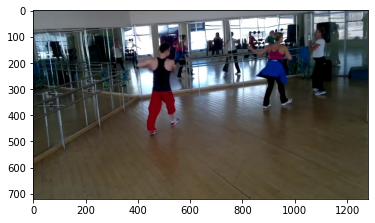

In [97]:
label = []
# x : (h 0), y : (w 1)
# print(train_df[train_df.index == 7104])
keypoints = train_df[train_df.index == 7104].iloc[:,1:-2].to_numpy()[0]
keypoints = keypoints.reshape(len(keypoints)//2, 2).astype(np.float32)
# human bbox : x center, y center, h, w -> w, h are reversed
human_bbox = train_df[train_df.index == 7104].iloc[:,-4:].to_numpy()[0]
joint_bbox = human_bbox[-2:]

for idx, k in enumerate(keypoints):
    if idx == 16:
        joint = [k[0]-joint_bbox[0]//2, k[1]-joint_bbox[1]//2,
            k[0]+joint_bbox[0]//2, k[1]+joint_bbox[1]//2]
    else:
        joint = [k[0]-joint_bbox[0]//40, k[1]-joint_bbox[1]//40,
                k[0]+joint_bbox[0]//40, k[1]+joint_bbox[1]//40]
    label.append(joint)

ttt = cv2.imread(IMG_PATH + train_df[train_df.index == 7104]['image_path'].to_numpy()[0])
ttt = cv2.cvtColor(ttt, cv2.COLOR_BGR2RGB).astype(np.float32)
ttt /= 255.
for bbox in label:
    ttt = cv2.rectangle(ttt, (int(bbox[0]), int(bbox[1])),
                        (int(bbox[2]), int(bbox[3])), color=(0,0,255), thickness=100)
# img_h = ttt.shape[0]
# img_w = ttt.shape[1]
# keypoints[:,0] /= img_h
# keypoints[:,1] /= img_w
plt.imshow(ttt)
plt.show()

# Build Model 

In [7]:
with tf.device(f'/device:GPU:{GPU}'):
    model = yoloV3(size=size, training=True, classes=num_classes)
    print(model.summary())
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 512)  11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 13, 13, 256)  2759680     yolo_conv_0[0][0]                
_____________________________________________________________________________________________

# Compile Model 

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = [yoloLoss(anchors[mask], classes=num_classes) for mask in anchor_masks]

In [9]:
model.compile(optimizer=optimizer, loss=loss)

callbacks = [
    ReduceLROnPlateau(verbose=1),
    EarlyStopping(patience=3, verbose=1),
    ModelCheckpoint('{CKPT_PATH}/yolov3_train_{epoch}.tf',
                   verbose=1,
                   save_weights_only=True),
    TensorBoard(log_dir='logs')
]

# Training 

In [ ]:
# history = model.fit(train_dataset,
#                    epochs=EPOCHS,
#                    callbacks=callbacks,
#                    validation_data=val_dataset)